# IS319 - Deep Learning

## TP2 - Dogs vs. cats (TensorFlow/Keras)

Credits: Baptiste Pesquet

![Woof Meow](woof_meow.jpg)

In this TP, the goal is to train neural networks to classify images of dogs and cats, using the TensorFlow/Keras library.

The images used in this TP are extracted from the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/) dataset available on Kaggle, which contains 25000 images. First, we use a subset of 2000 images to decrease training time, for educational purposes. Later on, you can experiment with the full dataset using a GPU.

Most questions are open-ended: feel free to experiment with different settings. **Remember to analyze and explain what you are doing in additional cells.**

## Environment setup

In [13]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Import TensorFlow modules (edit this list if needed)
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.applications import VGG16

TensorFlow version: 2.14.0


## Utility function

In [15]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""
    loss = history.history['loss']
    acc = history.history['accuracy']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

    plt.tight_layout()

## 1. Load and explore the dataset

In [16]:
# Downloading our example data, a .zip of 2000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate --no-clobber \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directories with training/validation cat/dogs pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

# Display the sizes of our dataset
print(f'Number of train cat images: {len(os.listdir(train_cats_dir))}')
print(f'Number of train dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Number of valid cat images: {len(os.listdir(valid_cats_dir))}')
print(f'Number of valid dog images: {len(os.listdir(valid_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
print(train_dog_fnames[:10])

File ‘/tmp/cats_and_dogs_filtered.zip’ already there; not retrieving.


Number of train cat images: 1000
Number of train dog images: 1000
Number of valid cat images: 500
Number of valid dog images: 500
['cat.978.jpg', 'cat.201.jpg', 'cat.9.jpg', 'cat.478.jpg', 'cat.542.jpg', 'cat.822.jpg', 'cat.399.jpg', 'cat.993.jpg', 'cat.770.jpg', 'cat.539.jpg']
['dog.360.jpg', 'dog.517.jpg', 'dog.802.jpg', 'dog.356.jpg', 'dog.645.jpg', 'dog.172.jpg', 'dog.880.jpg', 'dog.310.jpg', 'dog.75.jpg', 'dog.754.jpg']


**(Question)** Display some images of cats and dogs from the train set and the validation set.

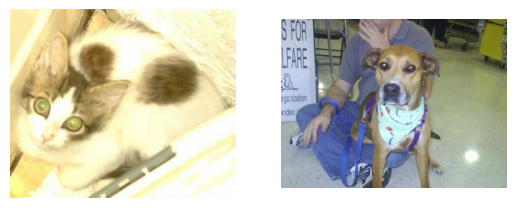

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the PNG image
img_cat = mpimg.imread(f"{train_cats_dir}/{train_cat_fnames[0]}")
img_dog = mpimg.imread(f"{train_dogs_dir}/{train_dog_fnames[0]}")

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(img_cat)
ax2.imshow(img_dog)
ax1.axis("off")  
ax2.axis("off")  
plt.show()



## 2. Prepare the dataset

**(Question)** Following the documentation, use the `tf.keras.utils.image_dataset_from_directory` function to create `train_dataset` and `valid_dataset` objects from the directory paths defined above. Make sure to have binary labels as we are doing binary classification. To start, you can use a lower image size (for example 128x128).

In [18]:
# YOUR CODE HERE
df_train = tf.keras.utils.image_dataset_from_directory(train_dir, labels='inferred',batch_size=2000)
df_valid = tf.keras.utils.image_dataset_from_directory(valid_dir, labels='inferred', batch_size=2000)



Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [19]:

for image_batch, labels_batch in df_train:
  X_train = image_batch.numpy()
  y_train = labels_batch.numpy()
  

for image_batch, labels_batch in df_valid:
  X_test = image_batch.numpy()
  y_test = labels_batch.numpy()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2000, 256, 256, 3) (1000, 256, 256, 3) (2000,) (1000,)


In [20]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print(np.mean(X_train), np.mean(X_test))

0.44716564 0.45160246


In [21]:
id = np.eye(2)
y_train_hot = id[y_train]
y_test_hot = id[y_test]

print(y_train_hot.shape, y_test_hot.shape)

(2000, 2) (1000, 2)


## 3. Training CNN models

**(Question)** Create a CNN classification model able to be trained on your dataset. Show its summary with the `model.summary()`method.
Make sure to include a layer to normalize input data (or to normalize your dataset object beforehand).

In [22]:
# YOUR CODE HERE

model = Sequential()

model.add(Conv2D(filters=4, kernel_size=5, padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(2,activation='softmax'))


model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train_hot, batch_size=32, epochs=10)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 252, 252, 4)       304       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 126, 126, 4)       0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 63504)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                4064320   
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 2)                 66        
                                                      

Epoch 1/10
63/63 [==============================] - 14s 219ms/step - loss: 0.7811 - accuracy: 0.5065
Epoch 2/10
63/63 [==============================] - 14s 218ms/step - loss: 0.6844 - accuracy: 0.6045
Epoch 3/10
63/63 [==============================] - 14s 219ms/step - loss: 0.6520 - accuracy: 0.6800
Epoch 4/10
63/63 [==============================] - 14s 220ms/step - loss: 0.5476 - accuracy: 0.7805
Epoch 5/10
63/63 [==============================] - 14s 219ms/step - loss: 0.3096 - accuracy: 0.8885
Epoch 6/10
63/63 [==============================] - 14s 220ms/step - loss: 0.1144 - accuracy: 0.9715
Epoch 7/10
63/63 [==============================] - 14s 220ms/step - loss: 0.0323 - accuracy: 0.9960
Epoch 8/10
54/63 [========================>.....] - ETA: 2s - loss: 0.0089 - accuracy: 0.9988

KeyboardInterrupt: 

**(Question)** "Compile" and train your model with an appropriate loss function. Monitor train and validation accuracy (you can use the `plot_loss_acc` function defined above). You should be able to reach a validation accuracy >70%. Analyze your results.

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_hot)

print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

ValueError: Data cardinality is ambiguous:
  x sizes: 2000
  y sizes: 1000
Make sure all arrays contain the same number of samples.

In [ ]:
# YOUR CODE HERE
plot_loss_acc(history)

**(Question)** Make sure your code is using a GPU if one is available. Modify your code accordingly, if necessary. What kind of speedup do you observe? 

## 4. Preventing overfitting

**(Question)** Experiment with various deep learning techniques to prevent overfitting.

Some suggested strategies are:

- Adding data augmentation: possible transformations are random (horizontal) flips, rotations, translations, crops, and zooms
    - (When using data augmentation, it is always good to visualize some of your transformations)
- Adding dropout to the classification part
- Adding appropriate batch normalization layers in different parts of the network

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**(Question)** Train your model with deep learning techniques. Analyze the results and compare with the previous model.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## 5. Finetuning a pretrained model

**(Question)** Load the feature extraction part of VGG16 model. The feature extraction part corresponds to the CNN part, without the MLP classifier at the end.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**(Question)** Add a custom MLP classifier on top of the VGG16 feature extraction part.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**(Question)** Compile and train your model. You should be able to reach a validation accuracy >87%. Analyze your results and compare with your initial model trained from scratch.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()